In [29]:
!pip install pandas

In [98]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas
import uuid

In [99]:
#import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [100]:
#Avoid OOM Errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [101]:
#Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [102]:
#Make our directories (Will give error if run and folders are already present, don't worry about that)
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [103]:
# Labeled Faces in the Wild
# http://vis-www.cs.umass.edu/lfw/

In [16]:
# Uncompress lfw.tgz dataset
!tar -xf lfw.tgz

In [18]:
# Move lfw images to the folowing repository data/negative
#if images are already moved, no need to run this cell
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
#establish connection to webcap
#number in parenthesis depends on each user, mine happend to be 0
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #cut frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]
    
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file pathq
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image            
        cv2.imwrite(imgname, frame)
            
    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)

    #show image back to screen
    cv2.imshow('Image Collection', frame)
    
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#Release the webcam
cap.release()
#Close image show frame
cv2.destroyAllWindows()

In [104]:
#getting datasets from captured images
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [105]:
def preprocess(file_path):
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    #Load in image
    img = tf.io.decode_jpeg(byte_img)
    #Resize image to 100x100x3
    img = tf.image.resize(img, (100, 100))
    #Scale image to be between 0 and 1
    img = img / 255.0
    #Return processed image
    return img

In [106]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) 
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) 
data = positives.concatenate(negatives)

In [107]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [108]:
# Build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [109]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [110]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [111]:
def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    #first block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding = 'same')(c1)
    
    #second block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
    
    #third block
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)
            
    #Final block
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [112]:
embedding = make_embedding()

In [113]:
# Siamese L1 Distance class
class L1Dist(Layer):
    #Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    #Magical shit - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [114]:
def make_siamese_model():
    # Anchor image in network
    input_image = Input(name = 'input_img', shape = (100, 100,3))
    
    #Validation image in network
    validation_image = Input(name = 'validation_img', shape = (100, 100, 3))
    
    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification Layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [115]:
avery_model = make_siamese_model()

In [116]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [117]:
opt = tf.keras.optimizers.Adam(1e-4)

In [118]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, avery_model=avery_model)

In [119]:
@tf.function
def train_step(batch):
    
    #Record all of our operations
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative images
        X = batch[:2]
        #Get label
        y = batch[2]
        
        #Forward pass
        yhat = avery_model(X, training = True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    #Calculate gradients
    grad = tape.gradient(loss, avery_model.trainable_variables)
    
    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, avery_model.trainable_variables))
    
    #Return loss
    return loss
                    

In [120]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}\{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
    # Loop through each batch
        for idx, batch in enumerate(data):
        #Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [121]:
EPOCH = 50

In [122]:
train(train_data, EPOCH)


 Epoch 1\50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 4s 121ms/step

 Epoch 2\50
27/27 [==============================] - 3s 115ms/step

 Epoch 3\50
27/27 [==============================] - 3s 115ms/step

 Epoch 4\50
27/27 [==============================] - 3s 114ms/step

 Epoch 5\50
27/27 [==============================] - 3s 114ms/step

 Epoch 6\50
27/27 [==============================] - 3s 114ms/step

 Epoch 7\50
27/27 [==============================] - 3s 114ms/step

 Epoch 8\50
27/27 [==============================] - 3s 114ms/step

 Epoch 9\50
27/27 [==============================] - 3s 114ms/step

 Epoch 10\50
27/27 [==============================] - 3s 114ms/step

 Epoch 11\50
27/27 [==============================] - 3s 114ms/step

 Epoch 12\50
27/27 [==============================] - 3s 113ms/step

 Epoch 13\50
27/27 [======

In [123]:
from tensorflow.keras.metrics import Precision, Recall

In [124]:
# Get batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [125]:
# Make predictions
y_hat = avery_model.predict([test_input, test_val])

In [126]:
# Post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]

In [127]:
# Creating a metric object
m = Recall()

# Calculating recall value
m.update_state(y_true, y_hat)

# Return result
m.result().numpy()

1.0

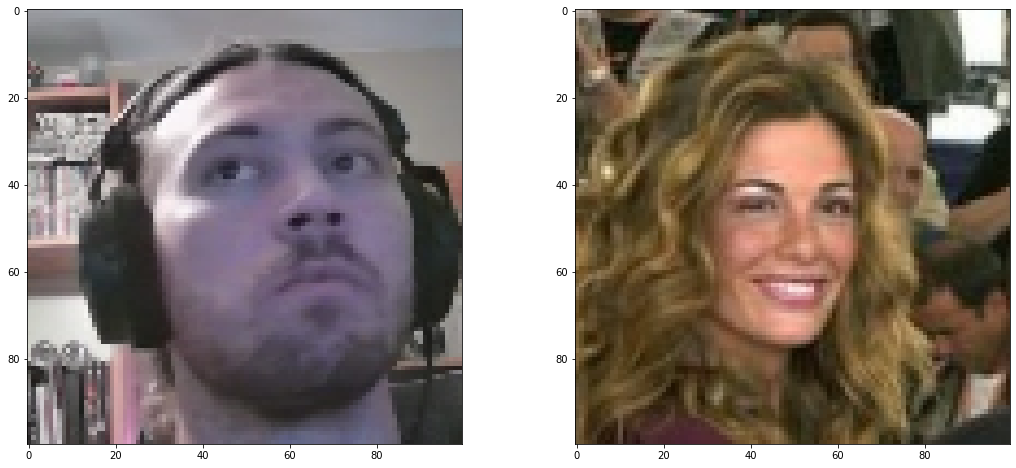

In [128]:
# Visualizing results

# Set plot size
plt.figure(figsize = (18,8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[3])

# Set Second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[3])

plt.show()

In [129]:
#save model(throws a warning, I don't know what it means, and it doesn't seem to effect anything)
avery_model.save('averymodel.h5')

In [130]:
#Reload model
model = tf.keras.models.load_model('averymodel.h5',
                                   custom_objects = {'L1Dist':L1Dist, 'BinaerCrossentropy':tf.losses.BinaryCrossentropy})

In [131]:
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
        
    #Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    #Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

In [132]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input Image to input folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        #Run Verification
        results, verified = verify(model, 0.75, 0.75)
        print(verified)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False
